### Import Packages

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# tokenization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# stopword removal
import nltk
import string
import re
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

# Vectorization/Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Neural Networks
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dropout, Input, Dense 
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed


datapath = 'data/'

### Load Data

In [102]:
data = pd.read_csv(datapath + 'disaster_train.csv', sep=',',)

### Tokenize data

we extract the text of the tweets as X vector and the transform them into a `tf-idf` (term-frequency times inverse document-frequency) matrix. 


In [103]:
# split feature vector and target vector
Y = data["target"].values 
X = data.values[:, 1:4]

# Get only column with tweet text
x_tweets = data['text']
x_keywords = data['keyword'].fillna('nan')
print(x_keywords.head())
print(x_tweets.head())

0    nan
1    nan
2    nan
3    nan
4    nan
Name: keyword, dtype: object
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


In [104]:
# Tweet tokenizer for making all alphabetical symbols lowercase, reducing length of words
# if they are e.g. 'goaaaal' and for removing account handles
tknzr = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
tweet_tokens = []
for sent in x_tweets:
    #print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tknzr.tokenize(sent))
print(tweet_tokens[:2])

[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]


In [105]:
# clean out stopwords, # signs, punctuation and numbers
clean_t2 = [[word if (word.startswith('#') == False) else re.sub(r'#', '', word) for word in tweet] for tweet in tweet_tokens]
clean_t3 = [[word for word in tweet if (word not in string.punctuation) and (word.isalpha() == True) and (word not in english_stopwords)] for tweet in clean_t2]
clean_t3[:2]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

In [106]:
# Transform into correct input form for the Vectorizer
clean_t4 = [' '.join(tweet) for tweet in clean_t3]
x_tweets = np.array(clean_t4)
x_tweets[:2]

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada'], dtype='<U138')

In [107]:
# stack preprocessed tweets and keywords back together
x_tweets_keywords = np.stack((x_tweets, x_keywords), axis=1)

In [110]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(x_tweets_keywords, Y, test_size=0.15, random_state=42, shuffle=True)

# create tf-idf vectorizer
tf_computer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))

# vectorize train and test set
train_features_tweets = tf_computer.fit_transform(X_train[:, 0])
test_features_tweets = tf_computer.transform(X_test[:, 0])
print("vocabulary size tweets:", len(tf_computer.vocabulary_))

train_features_keywords = tf_computer.fit_transform(X_train[:, 1])
test_features_keywords = tf_computer.transform(X_test[:, 1])
print("vocabulary size keywords:", len(tf_computer.vocabulary_))

# stack features together
train_features = hstack((train_features_tweets, train_features_keywords))
test_features = hstack((test_features_tweets, test_features_keywords))

vocabulary size tweets: 48914
vocabulary size keywords: 277


# Linear Classifiers
In the following we are going to try out different Linear Classifiers provided by sklearn. For each of those we will perform a gridsearch on the main parameters and print out the F1 score for the best fit. Following to that we will use the different simple classifiers to build one ensemle classifier.

### Logistic Regression

In [ ]:
# define grid search parameters 
param_grid = {
    'C': [0.5, 1, 5, 10]
}
# instantiate log reg object
lr = LogisticRegression()

#grid-search object
clf = GridSearchCV(estimator= lr, param_grid=param_grid, cv = 5, scoring = "accuracy")

#fit the model
clf.fit(train_features, y_train) #we do not use the train - validation split strategy since it is included in the CV procedure

#see the best parameters and performance
print(clf.best_params_)
print(clf.best_score_)

y_train_pred = clf.predict(train_features)
y_pred_test = clf.predict(test_features)
print(f"Logistic Regression.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

### SVM

In [100]:
#train the svc
svc_params = {
    'C': (0.1, 1., 10),
    'kernel': ('rbf', 'linear'),
}

clf = SVC(random_state=42)
clf_grid_svc = GridSearchCV(clf, svc_params, cv = 5, n_jobs= -1)
clf_grid_svc.fit(train_features, y_train)

# check out accuracy
y_train_pred = clf_grid_svc.predict(train_features)
y_test_pred = clf_grid_svc.predict(test_features)
print(f"SVC F1: \tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

SVC F1: 	Train:0.9658	Test:0.7749


In [96]:
from sklearn.metrics import classification_report

# Look at all metrics 
print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       681
           1       0.71      0.76      0.74       461

    accuracy                           0.78      1142
   macro avg       0.77      0.78      0.77      1142
weighted avg       0.78      0.78      0.78      1142



In [12]:
x_test = pd.DataFrame(X_test)
pred_df = pd.DataFrame(y_test_pred)
frame = [x_test, pred_df, pd.Series(y_test)]
# combine the tweet text with our classifications
result = pd.concat(frame, axis = 1)
result = result.reset_index()
result.columns = ['id', 'text', 'classification', 'true label']
# present some results
result.tail(10)

,id,text,classification
1132,1132,yo timeline blew damn fast,0
1133,1133,meek mill responds drake ûªs ovo fest set wedg...,0
1134,1134,tracy blight thank following,0
1135,1135,accident left lane blocked manchester rt nb ed...,1
1136,1136,deadpool already one favourite marvel characte...,0
1137,1137,warfighting robots could reduce civilian casua...,1
1138,1138,lives matter fan burning buildings stealing ne...,1
1139,1139,woman ûªs gps app guides rescuers injured bike...,1
1140,1140,tonight going mayhem everybody free w text st nw,0
1141,1141,ambulance right outside work,0


### RidgeClassifier

In [13]:
# select a linear model based on the assumption that specific words (linearly) imply a real disaster or not
ridge_params = {
    'alpha': (0.1, 1, 10),
    'fit_intercept': (True, False)
}

clf = RidgeClassifier(random_state=42)
clf_grid_ridge = GridSearchCV(clf, ridge_params, cv=5, n_jobs=-1)
clf_grid_ridge.fit(train_features, y_train)

# check out accuracy
y_train_pred = clf_grid_ridge.predict(train_features)
y_test_pred = clf_grid_ridge.predict(test_features)
print(f"Ridge F1: \tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

Ridge F1: 	Train:0.9373	Test:0.7879


### RandomForest

In [14]:
# we start with a grid search on a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
forest_params = {
    'n_estimators': (100, 500, 1000),
    'max_depth': (100, 500)
}

# perform gridsearch
clf = RandomForestClassifier(random_state=42)
clf_grid_forest = GridSearchCV(clf, forest_params, verbose=0, n_jobs=-1)
clf_grid_forest.fit(train_features, y_train)

# check performance
y_train_pred = clf_grid_forest.predict(train_features)
y_test_pred = clf_grid_forest.predict(test_features)
print(f"RandomForest f1: \tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

RandomForest f1: 	Train:0.9863	Test:0.7751


### Ensemble Method: StackingClassifier

In [ ]:
# lets put together the classifiers for our ensemble using the previously claculated optimal parameters.
estimators = [
    ('rf', RandomForestClassifier(**clf_grid_forest.best_params_, random_state=42)),
    ('svr', SVC(**clf_grid_svc.best_params_, random_state=42)),
    ('ridge', RidgeClassifier(**clf_grid_ridge.best_params_, random_state=42))
]

# fit our stacking classifier
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
results = cross_validate(clf, train_features, y_train, scoring=['accuracy', 'f1'] , cv=5, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.1min


In [29]:
print(results['test_accuracy'].mean())
print(results['test_f1'].mean())

0.8028122668926378
0.7564445724941771


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = clf.predict(test_features)
cm = confusion_matrix(y_test, y_test_pred, labels=clf_grid_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_grid_svc.classes_)
disp.plot()
plt.show()

AttributeError: This 'StackingClassifier' has no attribute 'predict'

Comment

# Neural Network
In this second part we are going to use a sequential neural network for the classification.

### Create early stopping mechanism for NN

In [112]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

np.random.seed(123)
set_random_seed(2)

### Transform data into a suitable input

In [113]:
# change to dense format
train_features_den = train_features.todense()
test_features_den = test_features.todense()
feature_vector_length = train_features_den.shape[1]

# one-hot-encoding of labels
n_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

In [114]:
# keras does not provide f1 as a metric during training, so we need to calculate it by hand using precision and recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

2022-01-21 11:59:44.467847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-21 11:59:44.467899: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-21 11:59:44.467929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (siprius): /proc/driver/nvidia/version does not exist
2022-01-21 11:59:44.468316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create and fit the NN

In [115]:
from keras.models import Sequential

# create model layers
model = Sequential() 
model.add(Dense(input_dim = feature_vector_length, units=200 , activation='relu')) 
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax')) #output layer

# configure the model and start training
model.compile(loss='binary_crossentropy', #loss metric
    optimizer='adam',  #optimizer
    metrics=['accuracy', precision, recall]) #displayed metric


history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=10, verbose=2, validation_split=0.2, callbacks=[es])

2022-01-21 11:59:46.805985: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1018450464 exceeds 10% of free system memory.


Epoch 1/10
52/52 - 5s - loss: 0.6035 - accuracy: 0.6953 - precision: 0.6953 - recall: 0.6953 - val_loss: 0.4744 - val_accuracy: 0.7876 - val_precision: 0.7876 - val_recall: 0.7876 - 5s/epoch - 103ms/step
Epoch 2/10
52/52 - 4s - loss: 0.2448 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - val_loss: 0.5002 - val_accuracy: 0.7853 - val_precision: 0.7853 - val_recall: 0.7853 - 4s/epoch - 86ms/step
Epoch 3/10
52/52 - 4s - loss: 0.0803 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - val_loss: 0.5779 - val_accuracy: 0.7792 - val_precision: 0.7792 - val_recall: 0.7792 - 4s/epoch - 84ms/step
Epoch 4/10
52/52 - 4s - loss: 0.0545 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - val_loss: 0.5896 - val_accuracy: 0.7730 - val_precision: 0.7730 - val_recall: 0.7730 - 4s/epoch - 84ms/step
Epoch 00004: early stopping


### Analyse the NN output

In [116]:
history_pd = pd.DataFrame(history.history)
history_pd['f1'] = 2/(1/history_pd['precision'] + 1/history_pd['recall'])
history_pd['val_f1'] = 2/(1/history_pd['val_precision'] + 1/history_pd['val_recall'])
print(history_pd)

       loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  0.603494  0.695325   0.695325  0.695325  0.474386      0.787645   
1  0.244827  0.906878   0.906878  0.906878  0.500160      0.785328   
2  0.080251  0.972372   0.972372  0.972372  0.577887      0.779151   
3  0.054462  0.978748   0.978748  0.978748  0.589584      0.772973   

   val_precision  val_recall        f1    val_f1  
0       0.787645    0.787645  0.695325  0.787645  
1       0.785328    0.785328  0.906878  0.785328  
2       0.779151    0.779151  0.972372  0.779151  
3       0.772973    0.772973  0.978748  0.772973  


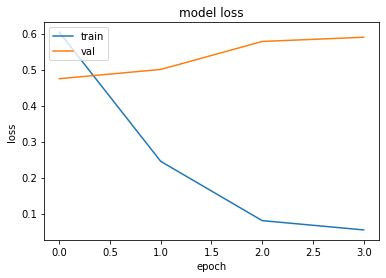

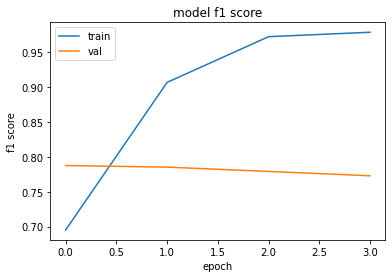

In [118]:
plt.plot(history_pd['loss'])
plt.plot(history_pd['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_pd['f1'])
plt.plot(history_pd['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.ylim(0.8, 1)
plt.show()


The training curves show a clear picture: the NN overfits our data. The train loss is reduced constantly and training f1 nealy reaches 0.98 but the validation loss increases over the epochs and validation f1 stays at about 0.78.

In [ ]:
y_proba = model.predict(train_features_den)
y_train_pred = y_proba.argmax(axis=-1)

y_proba = model.predict(test_features.todense())
y_test_pred = y_proba.argmax(axis=-1)

print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))
print('\nTrain accuracy score:', np.round(accuracy_score(y_train, y_train_pred), 3))
print('Test accuray score:', np.round(accuracy_score(y_test, y_test_pred), 3))

### Model Variation

In the following section we will try out different depths and activation functions for our model.

In [21]:
# the function can be used in a loop to define several models. The number of units per layer is decreased with every layer 
# to create a "bottleneck"
def MLP_definer(n_layers, n_features, n_classes, activation_f):
    
    model = Sequential()
    model.add(Dense(input_dim = n_features, units=500, activation=activation_f))
    for i in range(1, n_layers):
        model.add(Dense(units=500-10*i^2, activation=activation_f))
        
    model.add(Dense(units=n_classes, activation='softmax'))
    return model

In [22]:
out = {}
for fun in ('relu', 'sigmoid'):
    print(f'\n ## Activation function {fun} ############################################################################')
    for i in range(2,5):    
        model = MLP_definer(i, n_features=feature_vector_length, n_classes=n_classes, activation_f=fun)
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', precision, recall] #displayed metric
        )
        history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=20, verbose=0, validation_split=0.2, callbacks=[es])
        out[i] = [history.history['accuracy'][-1],  history.history['val_accuracy'][-1]]
        print(f'Number of layers: {i} \nTrain Acc: {history.history["accuracy"][-1]} \nTest Acc:  {history.history["val_accuracy"][-1]}\n')


 ## Activation function relu ############################################################################
Epoch 00004: early stopping
Number of layers: 2 
Train Acc: 0.9741112589836121 
Test Acc:  0.7722007632255554

Epoch 00004: early stopping
Number of layers: 3 
Train Acc: 0.9770092964172363 
Test Acc:  0.7783783674240112

Epoch 00004: early stopping
Number of layers: 4 
Train Acc: 0.9781684875488281 
Test Acc:  0.7760617733001709


 ## Activation function sigmoid ############################################################################
Epoch 00008: early stopping
Number of layers: 2 
Train Acc: 0.9462905526161194 
Test Acc:  0.7760617733001709

Epoch 00009: early stopping
Number of layers: 3 
Train Acc: 0.9518933296203613 
Test Acc:  0.7814671993255615

Epoch 00009: early stopping
Number of layers: 4 
Train Acc: 0.5608578324317932 
Test Acc:  0.5652509927749634



# Appendix

### Bagging Classifier

In [57]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


seed = 7
clf = DecisionTreeClassifier()
num_trees = 10
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_validate(model, train_features, y_train, scoring=['accuracy', 'f1'] , cv=5, verbose=2, n_jobs=-1)

print(results['test_accuracy'].mean())
print(results['test_f1'].mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_validate(clf, train_features, y_train, scoring=['accuracy', 'f1'] , cv=kfold, verbose=2, n_jobs=-1)

print(results['test_accuracy'].mean())
print(results['test_f1'].mean())